In [1]:
import pandas as pd
import numpy as np

import xgboost as xgb
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern,RationalQuadratic

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
from sklearn import metrics 
from sklearn.model_selection import KFold, GridSearchCV


import time
import random
from utils import data_handler, plotter

#handle warnings
import warnings
warnings.filterwarnings("ignore")

np.random.seed(3)

In [2]:
def test(y_pred,y_true):
    '''Evaluate the performance of model through 3 metrics: r^2, mse, pear
       
       Inputs:
           y_pred      - for testing
           y_true      - ground true for X_test
           
           
       Outputs:
           [r^2, mse,pear, pear_p_value] - np.array() 
               
    '''
    
    r2 = metrics.r2_score(y_true,y_pred)   
    mse = metrics.mean_squared_error(y_true,y_pred)
    [pear,p_value] = pearsonr(y_true,y_pred)
    

    return np.array([r2,mse,pear,p_value])

# Data Handling

In [3]:
X_df,Y_df = data_handler.load_XY(1)
X = X_df.as_matrix()
Y = Y_df.as_matrix()/100

loading CQD dataset...


# Model Selection

Generalization - Nested Cross Validatoin
1. Outer CV: 10-fold cross validation (10 repetitions)
2. Inner CV: 10-fold cross validation

In [5]:
# setup
verbose=False
n_jobs = 4
save_csv = True


# cross validation setup
Ntrials = 10
outter_nsplit = 10
inner_nsplits = 10

print('start  ',str(Ntrials),' trials...')
tot_count = Ntrials * outter_nsplit

# Results store
svr_mat = np.zeros((tot_count,4))
xgb_mat = np.zeros((tot_count,4))
mlp_mat = np.zeros((tot_count,4))
gpr_mat = np.zeros((tot_count,4))

for i in range(Ntrials):
    init_time = time.time()
    train_index = []  
    test_index = []  

    outer_cv = KFold(n_splits=outter_nsplit, shuffle=True, random_state=i+9)
    for train_ind,test_ind in outer_cv.split(Y):
        train_index.append(train_ind.tolist())
        test_index.append(test_ind.tolist())


    for j in range(outter_nsplit):#outter_nsplit
        count = i * outter_nsplit + j
        print(str(count), "  / ",str(tot_count))
        X_train = X[train_index[j]]
        Y_train = Y[train_index[j]]

        X_test = X[test_index[j]]
        Y_test = Y[test_index[j]]

        inner_cv = KFold(n_splits=inner_nsplits, shuffle=False, random_state=j)  


        # gpr
        kernel =  Matern(length_scale=1.0, length_scale_bounds=(1e-05, 100000.0), nu=1.5) +\
                RationalQuadratic(length_scale=1.0, alpha=1.0, length_scale_bounds=(1e-05, 100000.0), alpha_bounds=(1e-05, 100000.0)) 
        gpr_reg = Pipeline([            
                ('sc', StandardScaler()), 
                ('reg',  GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10))
                ])

        gpr_reg.fit(X_train, Y_train)
        y_pred = gpr_reg.predict(X_test)
        gpr_mat[count] = test(Y_test,y_pred)

        # SVR - rbf
        svr_rbf = Pipeline([            
                ('sc', StandardScaler()), 
                ('reg',  SVR())
                ])
        tuned_parameters = dict(reg__kernel=['rbf'],
                                reg__tol= [1e-3,1e-2,1e-1],
                                reg__C=[0.9,1,1.1],
                                reg__epsilon=[0,0.1,0.2],
                                reg__gamma=[1e-3,1e-2,1e-1,1/6]
                              )
        svr_cv = GridSearchCV(svr_rbf,tuned_parameters, cv=inner_cv, scoring='r2',verbose=verbose,n_jobs=n_jobs)
        svr_cv.fit(X_train, Y_train)
        y_pred = svr_cv.predict(X_test)
        svr_mat[count] = test(Y_test,y_pred)

        # GradientBoost
        tuned_parameters = dict(objective=["reg:linear"],
                            learning_rate=[0.01],
                            n_estimators=[300,500,700], #100,,300,400,500
                            colsample_bylevel = [0.5,0.7,0.9],
                          gamma=[0,0.2], #0,0.1,0.2,0.3,0.4
                          max_depth =[3,7,11], # [3,7,11]]
                          reg_lambda = [0.1,1,10], #[0.1,1,10]
                         # reg_alpha = [1],
                           subsample=[0.4,0.7,1])

        xgb_reg = xgb.XGBRegressor(min_child_weight=1,**{'tree_method':'exact'},
                                 silent=True,n_jobs=4,random_state=3,seed=3);

        xgb_cv = GridSearchCV(xgb_reg,tuned_parameters, cv=inner_cv,scoring='r2',verbose=verbose,n_jobs=4)
        xgb_cv.fit(X_train, Y_train)
        y_pred = xgb_cv.predict(X_test)
        xgb_mat[count] = test(Y_test,y_pred)


        # MLP
        mlp_clf = Pipeline([            
                ('sc', StandardScaler()), 
                ('reg',  MLPRegressor())
                ])
        tuned_parameters = dict(reg__hidden_layer_sizes=[[5],[10],[20],[5,5],[10,10],[20,20],[5,5,5],[10,10,10],[20,20,20]],
                          reg__alpha=[1e-4,1e-3, 1e-2, 1e-1,1], #L2 penalty (regularization term) parameter.
                          reg__early_stopping=[True],
                         reg__solver= ['lbfgs'])
        mlp_cv = GridSearchCV(mlp_clf, tuned_parameters, cv=inner_cv,scoring='r2',verbose=verbose,n_jobs=n_jobs)
        mlp_cv.fit(X_train, Y_train)
        y_pred = mlp_cv.predict(X_test)
        mlp_mat[count] = test(Y_test,y_pred)

        if verbose:
            print('svr - ',svr_mat[count])
            print('gpr - ',gpr_mat[count])
            print('mlp - ',mlp_mat[count])
            print('xgb -',xgb_mat[count])
    print((time.time()-init_time)/60, ' min')


mlp_results = pd.DataFrame(data =mlp_mat, columns=['r2','mse','pear','pear_p_val'])  
gpr_results = pd.DataFrame(data =gpr_mat, columns=['r2','mse','pear','pear_p_val'])         
xgb_results = pd.DataFrame(data =xgb_mat, columns=['r2','mse','pear','pear_p_val'])        
svr_results = pd.DataFrame(data =svr_mat, columns=['r2','mse','pear','pear_p_val'])   

if(save_csv):
    data_handler.save_csv(gpr_results, title='[model_selection_reg]gpr_results')
    data_handler.save_csv(mlp_results, title='[model_selection_reg]mlp_results')
    data_handler.save_csv(xgb_results, title='[model_selection_reg]xgb_results')
    data_handler.save_csv(svr_results, title='[model_selection_reg]svr_results')

print('end ',str(Ntrials),' trials')

start   1  trials...
0   /  5
1   /  5
2   /  5
3   /  5
4   /  5
23.974785590171813  min
Successfully saved : F:\projects\MoS2_Project_clean/results/[model_selection_reg]gpr_results2019_6_10.csv
Successfully saved : F:\projects\MoS2_Project_clean/results/[model_selection_reg]mlp_results2019_6_10.csv
Successfully saved : F:\projects\MoS2_Project_clean/results/[model_selection_reg]xgb_results2019_6_10.csv
Successfully saved : F:\projects\MoS2_Project_clean/results/[model_selection_reg]svr_results2019_6_10.csv
end  1  trials


# Determining Best Model
1. Comparing 4 performance metrics 
    - visualizing by boxplots
2. Bayesian correlated t-test
    - to verify recognizable difference between the best model versus other three candidates

In [6]:
np.random.seed(44)

print('->>>XGBoost_mean : \n',xgb_results.mean(axis=0), '\n  std = \n', xgb_results.std(axis=0))
print('->>>SVR_mean : \n',svr_results.mean(axis=0),' \n std =\n',svr_results.std(axis=0) )
print('->>>MLP_mean : \n',mlp_results.mean(axis=0), ' \n std =\n',mlp_results.std(axis=0))
print('->>>GPR_mean : \n',gpr_results.mean(axis=0), ' \n std =\n',gpr_results.std(axis=0))

->>>XGBoost_mean : 
 r2            8.522173e-01
mse           3.661192e-03
pear          9.353792e-01
pear_p_val    4.674260e-41
dtype: float64
->>>SVR_mean : 
 r2            6.700689e-01
mse           6.997863e-03
pear          8.733125e-01
pear_p_val    7.621773e-25
dtype: float64
->>>MLP_mean : 
 r2            8.058325e-01
mse           4.800040e-03
pear          9.135505e-01
pear_p_val    6.904992e-34
dtype: float64
->>>GPR_mean : 
 r2            7.692983e-01
mse           5.059765e-03
pear          9.086024e-01
pear_p_val    2.366102e-32
dtype: float64


Boxplot - r2/mse/pear of 4 candidate classifiers

In [8]:
labels = ['XGBoost-R','MLP-R' ,'SVM-R','GP-R']
n_results = outter_nsplit * Ntrials

r2_results_mat = np.zeros([n_results,4])
r2_results_mat[:,0] = xgb_results['r2']
r2_results_mat[:,1] = mlp_results['r2']
r2_results_mat[:,2] = svr_results['r2']
r2_results_mat[:,3] = gpr_results['r2']
r2_results = pd.DataFrame(data=r2_results_mat,columns=labels)

mse_results_mat = np.zeros([n_results,4])
mse_results_mat[:,0] = xgb_results['mse']
mse_results_mat[:,1] = mlp_results['mse']
mse_results_mat[:,2] = svr_results['mse']
mse_results_mat[:,3] = gpr_results['mse']
mse_results = pd.DataFrame(data=mse_results_mat,columns=labels)

pear_results_mat = np.zeros([n_results,4])
pear_results_mat[:,0] = xgb_results['pear']
pear_results_mat[:,1] = mlp_results['pear']
pear_results_mat[:,2] = svr_results['pear']
pear_results_mat[:,3] = gpr_results['pear']
pear_results = pd.DataFrame(data=pear_results_mat,columns= labels)

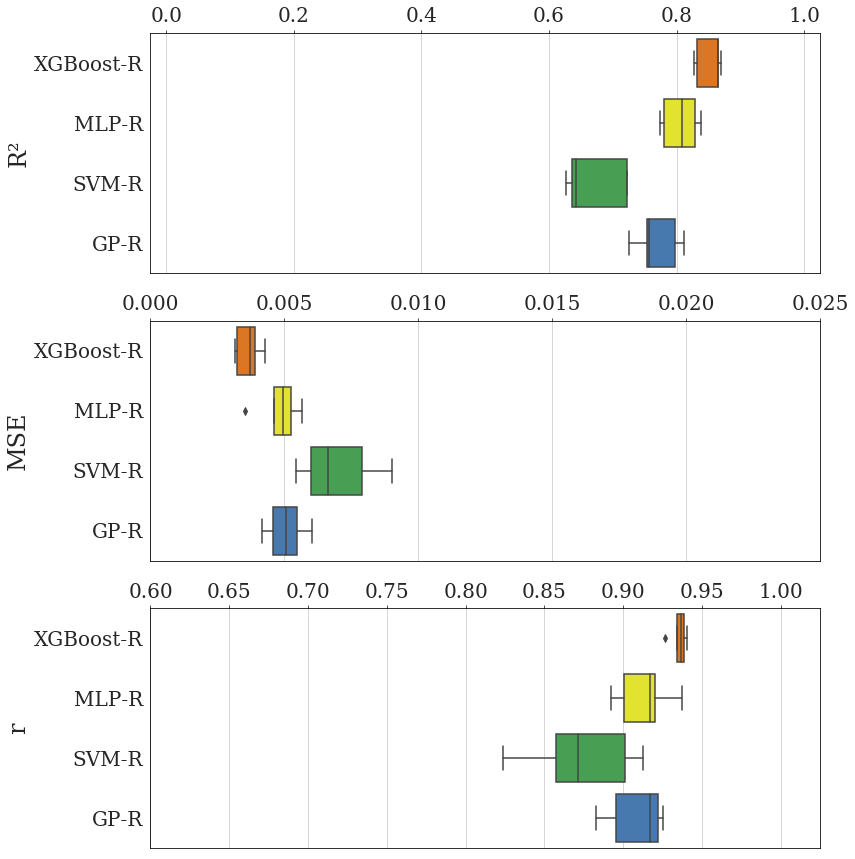

Successfully saved to:  F:\projects\MoS2_Project_clean/results/cqd_boxplot__boxplot2019_6_10.png


In [15]:
data = []
data.append(r2_results)
data.append(mse_results)
data.append(pear_results)
plotter.plot_boxplots(data=data, ylabels = [f'R\N{SUPERSCRIPT TWO}','MSE','r'],xmin=[-0.025,0,0.6],xmax=[1.025,0.025,1.025], toSaveFig=True,title='[model_selection_reg]cqd_')

In [11]:
rope=0.0
to_save = True
x_lims =  (-0.15,0.37)

P(SVM-R > XGBoost-R) = 0.0011506035149151704, P(rope) = 0.0, P(XGBoost-R > SVM-R) = 0.9988493964850849
Successfully saved to:  F:\projects\MoS2_Project_clean/results/XGBoost-R vs SVM-R on CQD dataset_ttest2019_6_10.png


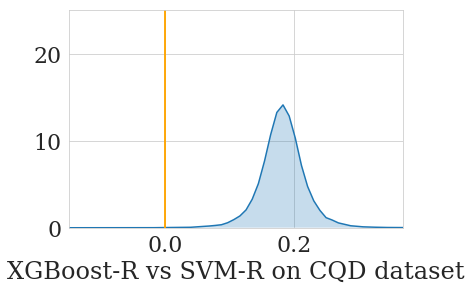

In [12]:
names = ( "SVM-R","XGBoost-R")
x=np.zeros((svr_results.shape[0],2),'float')
x[:,1]=xgb_results['r2']
x[:,0]=svr_results['r2']
title = names[1]+' vs ' +names[0]+' on CQD dataset'
left, within, right = plotter.plot_ttest(x, rope=rope,runs=Ntrials,verbose=True,names=names,title=title,toSaveFig=to_save, x_lims = x_lims)

P(GP-R > XGBoost-R) = 0.011346774376156754, P(rope) = 0.0, P(XGBoost-R > GP-R) = 0.9886532256238433
Successfully saved to:  F:\projects\MoS2_Project_clean/results/XGBoost-R vs GP-R on CQD dataset_ttest2019_6_10.png


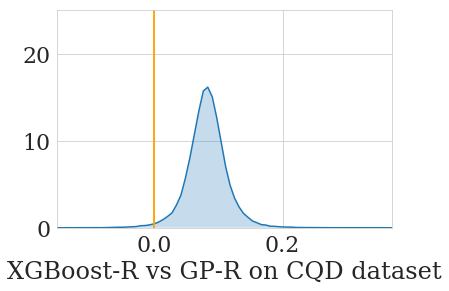

In [13]:
names = ( "GP-R","XGBoost-R")
x=np.zeros((gpr_results.shape[0],2),'float')
x[:,1]=xgb_results['r2']
x[:,0]=gpr_results['r2']
title = names[1]+' vs ' +names[0]+' on CQD dataset'
left, within, right = plotter.plot_ttest(x, rope=rope,runs=Ntrials,verbose=True,names=names,title=title,toSaveFig=to_save, x_lims = x_lims)

P(MLP-R > XGBoost-R) = 0.02394459650899975, P(rope) = 0.0, P(XGBoost-R > MLP-R) = 0.9760554034910003
Successfully saved to:  F:\projects\MoS2_Project_clean/results/XGBoost-R vs MLP-R on CQD dataset_ttest2019_6_10.png


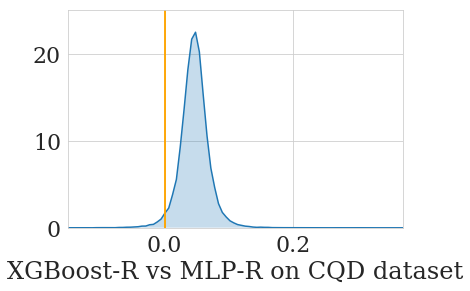

In [14]:
names = ( "MLP-R","XGBoost-R")
x=np.zeros((mlp_results.shape[0],2),'float')
x[:,1]=xgb_results['r2']
x[:,0]=mlp_results['r2']
title = names[1]+' vs ' +names[0]+' on CQD dataset'
left, within, right = plotter.plot_ttest(x, rope=rope,runs=Ntrials,verbose=True,names=names,title=title,toSaveFig=to_save, x_lims = x_lims)